
# Preprocessing Komprehensif (Rumah Sakit)



In [25]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

print(pd.__version__)


2.3.0


## 1) Pengumpulan & Inspeksi

In [26]:


file_path = "Hospital_Indonesia_datasets.csv"
df_raw = pd.read_csv(file_path, engine="python", sep=None)

print("Data Asli (5 baris pertama):")
print(df_raw.head())

print("\nInfo Data:")
print(df_raw.info())

print("\nMissing per kolom:")
print(df_raw.isnull().sum())


Data Asli (5 baris pertama):
        id                                   nama propinsi                kab  \
0  1110053                    RS Arun Lhokseumawe     Aceh   Kota Lhokseumawe   
1  1106014                        RS Umum Fandika     Aceh        Aceh Tengah   
2  1171110                 RS Umum Daerah Meuraxa     Aceh    Kota Banda Aceh   
3  1171163  RS Gigi Mulut Universitas Syiah Kuala     Aceh    Kota Banda Aceh   
4  1102027       RS Umum Daerah Kota Subulussalam     Aceh  Kota Subulussalam   

                                              alamat  \
0  Jl. Plaju Komplek Perumahan PT Arun Batuphat T...   
1  Jl. Terminal Simpang Wariji Blangkolak 1 Kec. ...   
2  Jl. Soekarno Hatta Km. 2 Desa Mibo Kecamatan B...   
3  Jl. Prof A. Madjid Ibrahim I No. 5 Banda Aceh ...   
4    Jl. Hamzah Fansyuri (Subulussalam-Rundeng) K...   

                               jenis kelas    status_blu       kepemilikan  \
0                   Rumah Sakit Umum     C  Non BLU/BLUD    SWASTA/LA

## 2) Normalisasi Header & Pemetaan Kolom

In [27]:


df_raw.columns = df_raw.columns.str.strip()

COL_ID = "id"
COL_NAMA = "nama"
COL_PROV = "propinsi"
COL_KAB = "kab"
COL_ALAMAT = "alamat"
COL_JENIS = "jenis"
COL_KELAS = "kelas"
COL_BLU = "status_blu"
COL_OWNER = "kepemilikan"
COL_TT = "total_tempat_tidur"
COL_LAYANAN = "total_layanan"
COL_TK = "total_tenaga_kerja"


needed = [COL_JENIS, COL_OWNER, COL_PROV]
missing = [c for c in needed if c not in df_raw.columns]
assert not missing, f"Kolom kunci tidak ditemukan: {missing}. Pastikan header sesuai."

df = df_raw.copy()


## 3) Normalisasi Nilai & Filter Hanya 'Rumah Sakit'

In [ ]:

HOSPITAL_ALIASES = {
    "RUMAH SAKIT", "RUMAH SAKIT UMUM", "RUMAH SAKIT KHUSUS",
    "RS", "RSU", "RSUD", "HOSPITAL", "GENERAL HOSPITAL", "SPECIALIST HOSPITAL"
}

for c in [COL_JENIS, COL_OWNER, COL_PROV]:
    df[c] = df[c].astype(str).str.strip()

df[COL_JENIS] = df[COL_JENIS].str.upper()
df[COL_OWNER] = df[COL_OWNER].str.title()
df[COL_PROV]  = df[COL_PROV].str.title()

def is_hospital(x: str) -> bool:
    x = str(x).upper().strip()
    return (x in HOSPITAL_ALIASES) or ("RUMAH SAKIT" in x) or (x.startswith("RS")) or ("HOSPITAL" in x)

df = df[df[COL_JENIS].apply(is_hospital)].copy()
print("Ukuran setelah filter RS:", df.shape)
display(df.head(5))


Ukuran setelah filter RS: (3151, 12)


,id,nama,propinsi,kab,alamat,jenis,kelas,status_blu,kepemilikan,total_tempat_tidur,total_layanan,total_tenaga_kerja
0,1110053,RS Arun Lhokseumawe,Aceh,Kota Lhokseumawe,Jl. Plaju Komplek Perumahan PT Arun Batuphat T...,RUMAH SAKIT UMUM,C,Non BLU/BLUD,Swasta/Lainnya,218,36,328
1,1106014,RS Umum Fandika,Aceh,Aceh Tengah,Jl. Terminal Simpang Wariji Blangkolak 1 Kec. ...,RUMAH SAKIT UMUM,D,Non BLU/BLUD,Swasta/Lainnya,45,15,45
2,1171110,RS Umum Daerah Meuraxa,Aceh,Kota Banda Aceh,Jl. Soekarno Hatta Km. 2 Desa Mibo Kecamatan B...,RUMAH SAKIT UMUM,B,BLUD,Pemkot,310,77,487
3,1171163,RS Gigi Mulut Universitas Syiah Kuala,Aceh,Kota Banda Aceh,Jl. Prof A. Madjid Ibrahim I No. 5 Banda Aceh ...,RUMAH SAKIT KHUSUS GIGI DAN MULUT,B,BLU,Kementerian Lain,11,24,0
4,1102027,RS Umum Daerah Kota Subulussalam,Aceh,Kota Subulussalam,Jl. Hamzah Fansyuri (Subulussalam-Rundeng) K...,RUMAH SAKIT UMUM,C,BLUD,Pemkot,189,34,537


## 4) Penanganan Nilai Hilang

In [29]:

numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
categorical_cols = [c for c in df.columns if c not in numeric_cols]

print("Numerik:", numeric_cols)
print("Kategorikal:", categorical_cols)

# Imputasi numerik: median
for c in numeric_cols:
    if df[c].isnull().any():
        df[c] = df[c].fillna(df[c].median())

# Imputasi kategorikal: mode (fallback 'Tidak Diketahui')
NEW_CATEGORY_LABEL = "Tidak Diketahui"
for c in categorical_cols:
    if df[c].isnull().any():
        mode_val = df[c].mode(dropna=True)
        mode_val = mode_val.iloc[0] if not mode_val.empty else NEW_CATEGORY_LABEL
        df[c] = df[c].fillna(mode_val)

print("Cek missing setelah imputasi:")
display(df.isnull().sum())


Numerik: ['id', 'total_tempat_tidur', 'total_layanan', 'total_tenaga_kerja']
Kategorikal: ['nama', 'propinsi', 'kab', 'alamat', 'jenis', 'kelas', 'status_blu', 'kepemilikan']
Cek missing setelah imputasi:


id                    0
nama                  0
propinsi              0
kab                   0
alamat                0
jenis                 0
kelas                 0
status_blu            0
kepemilikan           0
total_tempat_tidur    0
total_layanan         0
total_tenaga_kerja    0
dtype: int64

## 5) Kategorikal & High Cardinality → One-Hot Encoding

In [30]:

LOW_FREQ_THRESHOLD = 0.01

def collapse_low_freq(series: pd.Series, threshold=LOW_FREQ_THRESHOLD, label="Lain-Lain"):
    freq = series.value_counts(dropna=False, normalize=True)
    low = freq[freq < threshold].index
    return series.apply(lambda x: label if x in low else x)

categorical_processed = df[categorical_cols].copy()
for c in categorical_processed.columns:
    if categorical_processed[c].nunique(dropna=False) > 10:
        categorical_processed[c] = collapse_low_freq(categorical_processed[c])

df_ohe = pd.get_dummies(categorical_processed, drop_first=False, dtype=int)
df_num = df[numeric_cols].copy()
df_prepared = pd.concat([df_num.reset_index(drop=True), df_ohe.reset_index(drop=True)], axis=1)

print("Dimensi setelah OHE:", df_prepared.shape)
display(df_prepared.head(5))


Dimensi setelah OHE: (3151, 75)


,id,total_tempat_tidur,total_layanan,total_tenaga_kerja,nama_Lain-Lain,propinsi_Aceh,propinsi_Bali,propinsi_Banten,propinsi_Dki Jakarta,propinsi_Jambi,...,kepemilikan_Organisasi Katholik,kepemilikan_Organisasi Sosial,kepemilikan_Pemkab,kepemilikan_Pemkot,kepemilikan_Pemprop,kepemilikan_Perorangan,kepemilikan_Perusahaan,kepemilikan_Polri,kepemilikan_Swasta/Lainnya,kepemilikan_Tni Ad
0,1110053,218,36,328,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1106014,45,15,45,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1171110,310,77,487,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1171163,11,24,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1102027,189,34,537,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## 6) Outlier (Winsorization 3×IQR)

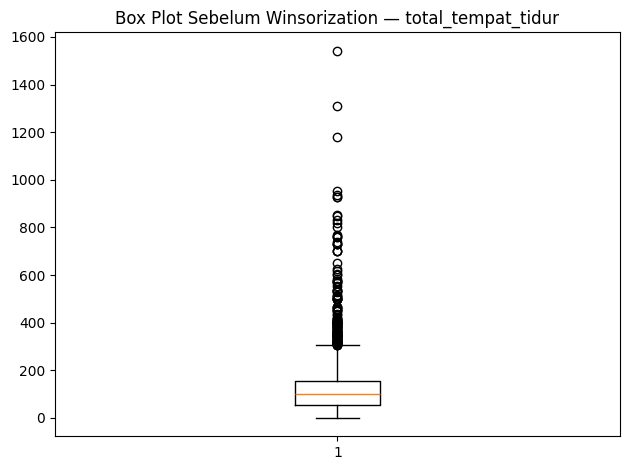

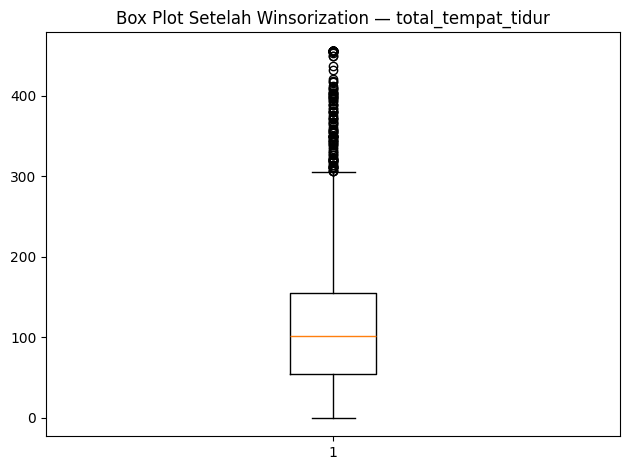

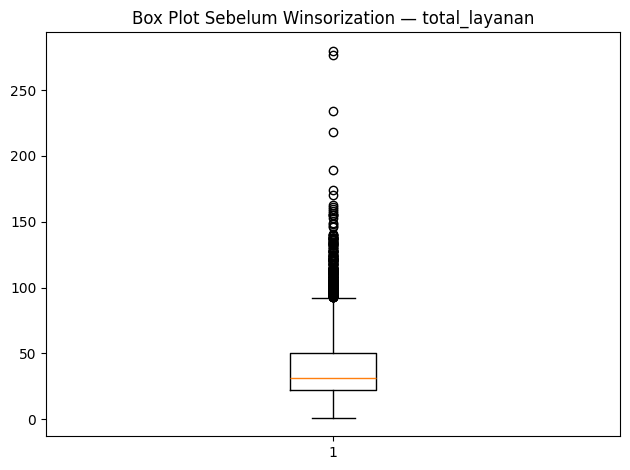

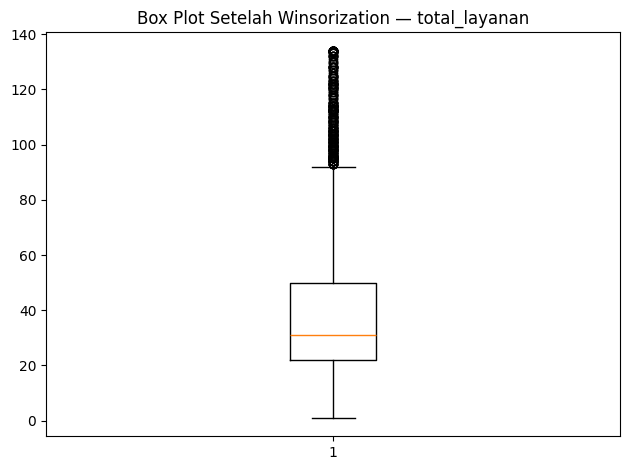

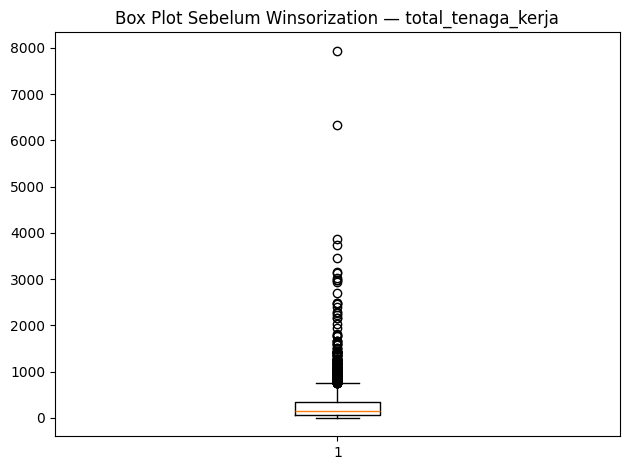

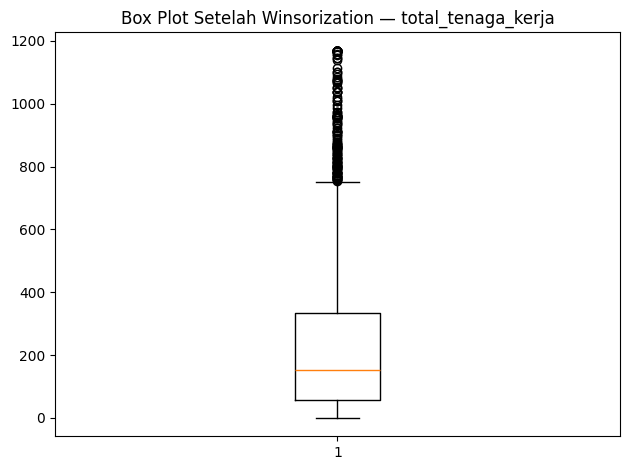

In [31]:

def winsorize_iqr(series: pd.Series, k=3.0):
    q1 = series.quantile(0.25); q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return series.clip(lower, upper)

key_numeric = [c for c in [COL_TT, COL_LAYANAN, COL_TK] if c in df_prepared.columns] or df_prepared.select_dtypes(include=[np.number]).columns.tolist()[:1]

for c in key_numeric:
    plt.figure()
    plt.boxplot(df_prepared[c].dropna().values)
    plt.title(f"Box Plot Sebelum Winsorization — {c}")
    plt.tight_layout()
    plt.show()

    df_prepared[c] = winsorize_iqr(df_prepared[c])

    plt.figure()
    plt.boxplot(df_prepared[c].dropna().values)
    plt.title(f"Box Plot Setelah Winsorization — {c}")
    plt.tight_layout()
    plt.show()


## 7) Penskalaan Fitur (fit hanya pada train)

In [32]:

SCALING = "minmax"  # atau 'standard'
train_df, test_df = train_test_split(df_prepared, test_size=0.2, random_state=42)

scaler = MinMaxScaler() if SCALING == "minmax" else StandardScaler()
num_cols_all = train_df.select_dtypes(include=[np.number]).columns.tolist()

train_scaled = train_df.copy()
test_scaled = test_df.copy()
train_scaled[num_cols_all] = scaler.fit_transform(train_df[num_cols_all])
test_scaled[num_cols_all]  = scaler.transform(test_df[num_cols_all])

print("Train/Test:", train_scaled.shape, test_scaled.shape)
display(train_scaled.head(3))
display(test_scaled.head(3))


Train/Test: (2520, 75) (631, 75)


,id,total_tempat_tidur,total_layanan,total_tenaga_kerja,nama_Lain-Lain,propinsi_Aceh,propinsi_Bali,propinsi_Banten,propinsi_Dki Jakarta,propinsi_Jambi,...,kepemilikan_Organisasi Katholik,kepemilikan_Organisasi Sosial,kepemilikan_Pemkab,kepemilikan_Pemkot,kepemilikan_Pemprop,kepemilikan_Perorangan,kepemilikan_Perusahaan,kepemilikan_Polri,kepemilikan_Swasta/Lainnya,kepemilikan_Tni Ad
1295,0.266339,0.028509,0.082707,0.073567,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2737,0.649321,0.368421,0.338346,0.141146,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
764,0.253425,0.173246,0.413534,0.277160,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,id,total_tempat_tidur,total_layanan,total_tenaga_kerja,nama_Lain-Lain,propinsi_Aceh,propinsi_Bali,propinsi_Banten,propinsi_Dki Jakarta,propinsi_Jambi,...,kepemilikan_Organisasi Katholik,kepemilikan_Organisasi Sosial,kepemilikan_Pemkab,kepemilikan_Pemkot,kepemilikan_Pemprop,kepemilikan_Perorangan,kepemilikan_Perusahaan,kepemilikan_Polri,kepemilikan_Swasta/Lainnya,kepemilikan_Tni Ad
3141,1.000000,0.285088,0.345865,0.216424,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1839,0.295484,0.144737,0.210526,0.094953,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2285,0.306260,0.223684,0.165414,0.085543,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 8) Agregasi: Propinsi × Kepemilikan

In [33]:

def norm_owner(x: str) -> str:
    up = str(x).upper()
    if any(k in up for k in ["PEMERINTAH", "KEMENTERIAN", "PEMDA", "RSUD", "TNI", "POLRI", "NEG", "STATE", "GOV"]):
        return "Pemerintah"
    if any(k in up for k in ["SWASTA", "PRIVATE", "YAYASAN", "COMPANY", "PT "]):
        return "Swasta"
    return str(x).title()

df_agg = df.copy()
df_agg[COL_OWNER] = df_agg[COL_OWNER].map(norm_owner)

agg = df_agg.groupby([COL_PROV, COL_OWNER]).size().reset_index(name="jumlah")
wide = (agg.pivot(index=COL_PROV, columns=COL_OWNER, values="jumlah").fillna(0).rename_axis(None, axis=1))
for col in ["Pemerintah", "Swasta"]:
    if col not in wide.columns:
        wide[col] = 0
wide["Total"] = wide["Pemerintah"] + wide["Swasta"]
wide = wide.sort_values("Total", ascending=False)

display(wide.head(10))


,Bumn,Kemkes,Organisasi Budha,Organisasi Hindu,Organisasi Islam,Organisasi Katholik,Organisasi Protestan,Organisasi Sosial,Pemerintah,Pemkab,Pemkot,Pemprop,Perorangan,Perusahaan,Swasta,Total
propinsi,,,,,,,,,,,,,,,,
Jawa Timur,2.0,2.0,0.0,0.0,21.0,2.0,4.0,23.0,30.0,62.0,10.0,14.0,7.0,43.0,212.0,242.0
Jawa Barat,3.0,5.0,0.0,0.0,6.0,3.0,2.0,35.0,19.0,44.0,19.0,6.0,5.0,118.0,156.0,175.0
Jawa Tengah,1.0,5.0,0.0,0.0,58.0,6.0,4.0,51.0,17.0,54.0,9.0,7.0,7.0,51.0,84.0,101.0
Dki Jakarta,4.0,10.0,1.0,0.0,4.0,3.0,2.0,28.0,17.0,0.0,0.0,30.0,2.0,27.0,59.0,76.0
Banten,1.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,4.0,8.0,7.0,2.0,1.0,38.0,61.0,65.0
Sumatera Utara,7.0,1.0,0.0,0.0,0.0,4.0,2.0,39.0,11.0,33.0,8.0,5.0,6.0,52.0,34.0,45.0
Sulawesi Selatan,1.0,4.0,0.0,0.0,3.0,1.0,0.0,13.0,10.0,36.0,5.0,8.0,8.0,9.0,25.0,35.0
Bali,0.0,1.0,0.0,2.0,0.0,0.0,0.0,9.0,4.0,14.0,1.0,3.0,2.0,13.0,30.0,34.0
Riau,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,5.0,15.0,2.0,3.0,3.0,24.0,24.0,29.0


## 9) Simpan Output

In [34]:

OUT = Path("outputs_rs_v5")
OUT.mkdir(exist_ok=True, parents=True)

df_prepared.to_csv(OUT / "dataset_prepared_ohe_winsor.csv", index=False)
train_scaled.to_csv(OUT / "data_latih_scaled.csv", index=False)
test_scaled.to_csv(OUT / "data_uji_scaled.csv", index=False)
wide.reset_index().to_csv(OUT / "agregasi_propinsi_kepemilikan.csv", index=False)

print("Tersimpan di:", OUT.resolve())


Tersimpan di: C:\Users\Pongo\Downloads\outputs_rs_v5


## 10) Visualisasi Agregasi

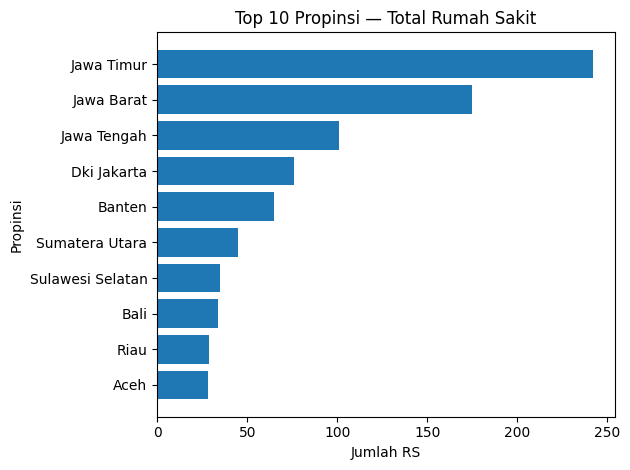

In [35]:

top10 = wide.head(10).sort_values("Total", ascending=True)

plt.figure()
plt.barh(top10.index, top10["Total"])
plt.title("Top 10 Propinsi — Total Rumah Sakit")
plt.xlabel("Jumlah RS")
plt.ylabel("Propinsi")
plt.tight_layout()
plt.show()


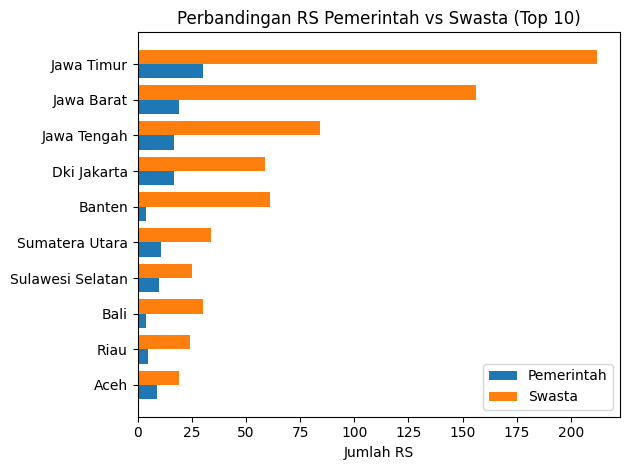

In [36]:

top10_ns = wide.head(10).sort_values("Total", ascending=True)

plt.figure()
bar_width = 0.4
y = np.arange(top10_ns.shape[0])
plt.barh(y - bar_width/2, top10_ns["Pemerintah"].values, height=bar_width, label="Pemerintah")
plt.barh(y + bar_width/2, top10_ns["Swasta"].values, height=bar_width, label="Swasta")
plt.yticks(y, top10_ns.index)
plt.title("Perbandingan RS Pemerintah vs Swasta (Top 10)")
plt.xlabel("Jumlah RS")
plt.legend()
plt.tight_layout()
plt.show()


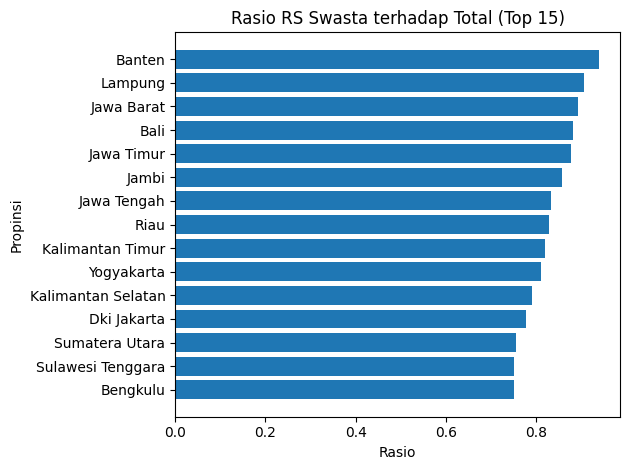

In [37]:

ratio = (wide.assign(rasio_swasta = np.where(wide["Total"]>0, wide["Swasta"]/wide["Total"], 0))
               .sort_values("rasio_swasta", ascending=False)
               .head(15))

plt.figure()
plt.barh(ratio.index[::-1], ratio["rasio_swasta"].values[::-1])
plt.title("Rasio RS Swasta terhadap Total (Top 15)")
plt.xlabel("Rasio")
plt.ylabel("Propinsi")
plt.tight_layout()
plt.show()


## 11) Verifikasi Akhir & Ringkasan

In [38]:

print("Head data prepared:")
display(df_prepared.head(5))

print("\nTotal missing di data prepared:", df_prepared.isnull().sum().sum())
print("\nKolom bertipe object (seharusnya kosong jika OHE sukses):", df_prepared.select_dtypes(include="object").columns.tolist())

print("""
Ringkasan Keputusan:
- Loader terkunci pada nama file 'Hospital_Indonesia_datasets' (CSV/Excel).
- Imputasi numerik: Median; kategorikal: Mode (fallback 'Tidak Diketahui').
- High cardinality: <1% → 'Lain-Lain' → OHE.
- Outlier: Winsorization 3×IQR.
- Penskalaan: MinMaxScaler (fit train), transform ke train & test.
- Agregasi: Propinsi × Kepemilikan + 3 grafik.
""" )


Head data prepared:


,id,total_tempat_tidur,total_layanan,total_tenaga_kerja,nama_Lain-Lain,propinsi_Aceh,propinsi_Bali,propinsi_Banten,propinsi_Dki Jakarta,propinsi_Jambi,...,kepemilikan_Organisasi Katholik,kepemilikan_Organisasi Sosial,kepemilikan_Pemkab,kepemilikan_Pemkot,kepemilikan_Pemprop,kepemilikan_Perorangan,kepemilikan_Perusahaan,kepemilikan_Polri,kepemilikan_Swasta/Lainnya,kepemilikan_Tni Ad
0,1110053,218,36,328,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1106014,45,15,45,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1171110,310,77,487,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1171163,11,24,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1102027,189,34,537,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0



Total missing di data prepared: 0

Kolom bertipe object (seharusnya kosong jika OHE sukses): []

Ringkasan Keputusan:
- Loader terkunci pada nama file 'Hospital_Indonesia_datasets' (CSV/Excel).
- Imputasi numerik: Median; kategorikal: Mode (fallback 'Tidak Diketahui').
- High cardinality: <1% → 'Lain-Lain' → OHE.
- Outlier: Winsorization 3×IQR.
- Penskalaan: MinMaxScaler (fit train), transform ke train & test.
- Agregasi: Propinsi × Kepemilikan + 3 grafik.



In [39]:
# === 11) VERIFIKASI AKHIR (Console + File) ===
import io
from pathlib import Path
import pandas as pd

# Pilih dataframe yang mau diverifikasi
# (prioritas train_scaled; fallback ke df_prepared)
df_check_name = None
if 'train_scaled' in globals():
    df_check = train_scaled
    df_check_name = "train_scaled"
elif 'df_prepared' in globals():
    df_check = df_prepared
    df_check_name = "df_prepared"
else:
    raise RuntimeError("Tidak menemukan 'train_scaled' atau 'df_prepared' untuk diverifikasi.")

print(f"=== Verifikasi Data: {df_check_name} ===\n")

# Tampilkan 8 baris pertama
print("Menampilkan 8 baris pertama:")
try:
    display(df_check.head(8))
except NameError:
    print(df_check.head(8).to_string())

# Missing per kolom
print("\n--- Jumlah nilai hilang per kolom ---")
na_counts = df_check.isnull().sum()
print(na_counts.to_string())

# Tipe data tiap kolom (paksa tampil penuh seperti di screenshot)
print("\n--- Tipe data tiap kolom ---")
buf = io.StringIO()
df_check.info(buf=buf, memory_usage='deep')
info_text = buf.getvalue()
print(info_text.split("Data columns")[0])          # header info
print("Data columns (total {} columns):".format(df_check.shape[1]))
print(df_check.dtypes.astype(str).to_string())     # daftar dtypes ringkas
print("\nTotal rows:", df_check.shape[0])

# Deteksi kolom object (string) – cek di df_prepared bila ada, else di df_check
print("\n!!! TERDETEKSI KOLOM BERTIPE 'object' (string):")
if 'df_prepared' in globals():
    obj_cols = df_prepared.select_dtypes(include='object').columns.tolist()
else:
    obj_cols = df_check.select_dtypes(include='object').columns.tolist()

if obj_cols:
    for c in obj_cols:
        print("-", c)
else:
    print("- (tidak ada)")

# ===== Simpan ringkasan ke file =====
OUT = Path("outputs_rs_verify")
OUT.mkdir(exist_ok=True, parents=True)

ringkas_path = OUT / "laporan_ringkas_verifikasi.txt"
detail_path  = OUT / "verifikasi_summary.txt"

# Ringkas
with open(ringkas_path, "w", encoding="utf-8") as f:
    f.write(f"=== Verifikasi Ringkas: {df_check_name} ===\n")
    f.write(f"Shape: {df_check.shape}\n")
    f.write(f"Total missing: {int(na_counts.sum())}\n")
    f.write("Kolom object: " + (", ".join(obj_cols) if obj_cols else "(tidak ada)") + "\n")

# Detail (head, missing, dtypes)
with open(detail_path, "w", encoding="utf-8") as f:
    f.write(f"=== Verifikasi Detail: {df_check_name} ===\n")
    f.write("\n-- Head (8 baris) --\n")
    f.write(df_check.head(8).to_string())
    f.write("\n\n-- Missing per kolom --\n")
    f.write(na_counts.to_string())
    f.write("\n\n-- Dtypes --\n")
    f.write(df_check.dtypes.astype(str).to_string())
    f.write("\n")

print("\nLaporan ringkas disimpan sebagai:", ringkas_path.resolve())
print("Ringkasan verifikasi disimpan sebagai:", detail_path.resolve())


=== Verifikasi Data: train_scaled ===

Menampilkan 8 baris pertama:


,id,total_tempat_tidur,total_layanan,total_tenaga_kerja,nama_Lain-Lain,propinsi_Aceh,propinsi_Bali,propinsi_Banten,propinsi_Dki Jakarta,propinsi_Jambi,...,kepemilikan_Organisasi Katholik,kepemilikan_Organisasi Sosial,kepemilikan_Pemkab,kepemilikan_Pemkot,kepemilikan_Pemprop,kepemilikan_Perorangan,kepemilikan_Perusahaan,kepemilikan_Polri,kepemilikan_Swasta/Lainnya,kepemilikan_Tni Ad
1295,0.266339,0.028509,0.082707,0.073567,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2737,0.649321,0.368421,0.338346,0.141146,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
764,0.253425,0.173246,0.413534,0.277160,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1494,0.272702,0.745614,0.624060,0.686912,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2805,0.755199,0.296053,0.939850,0.164243,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221,0.021410,0.256579,0.165414,0.011121,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
543,0.061934,0.359649,0.180451,0.047049,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1344,0.258387,0.212719,0.165414,0.215569,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0



--- Jumlah nilai hilang per kolom ---
id                                         0
total_tempat_tidur                         0
total_layanan                              0
total_tenaga_kerja                         0
nama_Lain-Lain                             0
propinsi_Aceh                              0
propinsi_Bali                              0
propinsi_Banten                            0
propinsi_Dki Jakarta                       0
propinsi_Jambi                             0
propinsi_Jawa Barat                        0
propinsi_Jawa Tengah                       0
propinsi_Jawa Timur                        0
propinsi_Kalimantan Barat                  0
propinsi_Kalimantan Selatan                0
propinsi_Kalimantan Tengah                 0
propinsi_Kalimantan Timur                  0
propinsi_Kepulauan Riau                    0
propinsi_Lain-Lain                         0
propinsi_Lampung                           0
propinsi_Nusa Tenggara Barat               0
propinsi_Nusa Te